In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
funding_rounds_df = pd.read_csv('/content/drive/MyDrive/Series A-nalysts/archive/funding_rounds.csv')
objects_df = pd.read_csv('/content/drive/MyDrive/Series A-nalysts/archive/objects.csv')

<ipython-input-2-35a9b52b15c3>:4: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects_df = pd.read_csv('/content/drive/MyDrive/Series A-nalysts/archive/objects.csv')


###Now we merge the objects_df which has all the companies' information and funding_rounds_df which has the information for funding rounds for each company into one dataframe

In [ ]:
full_df = pd.merge(objects_df, funding_rounds_df, left_on="id", right_on="object_id", how="inner")

NameError: ignored

### This is a simplification of our data and we can quickly see what to expect from our data.

In [ ]:
full_df_simplified = full_df[['id_x',  'founded_at', 'funding_rounds', 'funded_at', 'raised_amount_usd',  'is_last_round']]

###Here we fill na fields with the median and convert dates to datetime format. We also add columns such as company age at funding which is a numerical value. This allows our models to analyze the datetime information.

In [ ]:
# Sort the data
full_df_simplified = full_df_simplified.sort_values(by=['id_x', 'funded_at'])
full_df_simplified = full_df_simplified[full_df_simplified['raised_amount_usd'] < 40000000] #40, 100

# Calculate cumulative sum of raised_amount_usd and current number of funding rounds
full_df_simplified['total_funding_until_this_point'] = full_df_simplified.groupby('id_x')['raised_amount_usd'].cumsum()
full_df_simplified['current_number_of_funding_rounds'] = full_df_simplified.groupby('id_x').cumcount() + 1

# Convert dates to datetime and create time features
full_df_simplified['founded_at'] = pd.to_datetime(full_df_simplified['founded_at'])
full_df_simplified['funded_at'] = pd.to_datetime(full_df_simplified['funded_at'])
full_df_simplified['company_age_at_funding'] = (full_df_simplified['funded_at'] - full_df_simplified['founded_at']).dt.days
full_df_simplified['time_since_last_round'] = full_df_simplified.groupby('id_x')['funded_at'].diff().dt.days.fillna(0)

# Shift target variable and drop rows where target is NaN
full_df_simplified['next_round_raised_amount_usd'] = full_df_simplified.groupby('id_x')['raised_amount_usd'].shift(-1)
full_df_simplified = full_df_simplified.dropna(subset=['next_round_raised_amount_usd'])

###Drop columns that have really low correlations or aren't used for prediction or that we repurposed into new columns

In [ ]:
full_df_simplified.drop(columns=['id_x', 'is_last_round', 'founded_at', 'funded_at'], inplace=True)

###Scale numerical columns

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Columns to scale
numerical_cols = ['raised_amount_usd', 'total_funding_until_this_point', 'company_age_at_funding', 'time_since_last_round']

# Standardizing these columns
scaler = StandardScaler()
full_df_simplified[numerical_cols] = scaler.fit_transform(full_df_simplified[numerical_cols])

# Fill missing values with the median
full_df_simplified = full_df_simplified.fillna(full_df_simplified.median())


###Filtering of data on round raised amount

In [ ]:
full_df_simplified = full_df_simplified[full_df_simplified['current_number_of_funding_rounds'] < 4]

full_df_simplified_less = full_df_simplified[full_df_simplified['next_round_raised_amount_usd'] < 20000000] #<> 20
full_df_simplified_more = full_df_simplified[full_df_simplified['next_round_raised_amount_usd'] >= 20000000] #<> 20

full_df_simplified

,funding_rounds,raised_amount_usd,total_funding_until_this_point,current_number_of_funding_rounds,company_age_at_funding,time_since_last_round,next_round_raised_amount_usd
0,3,-0.114799,-0.320325,1,-0.810562,-0.529362,9500000.0
1,3,0.294352,0.078349,2,-0.550148,0.703190,25000000.0
5,5,-0.427680,-0.456713,1,-0.587757,-0.529362,9000000.0
6,5,0.246217,-0.079023,2,-0.188874,1.358574,2069200.0
9,5,-0.421018,0.007813,3,0.083507,0.759828,12000000.0
...,...,...,...,...,...,...,...
52611,5,-0.591340,-0.528055,1,-0.298851,-0.529362,1200000.0
52612,5,-0.504696,-0.477696,2,-0.043566,0.678917,6000000.0
52613,5,-0.042596,-0.225902,3,0.180948,0.533276,15000000.0
52620,2,-0.562459,-0.515465,1,-0.431053,-0.529362,500000.0


---



---

# END OF DATA PREPROCESSING

---



---



Best lambda value: 100
Test MSE for best Ridge model: 208409710054411.2
RMSE for best Ridge model: 14436402.254523499


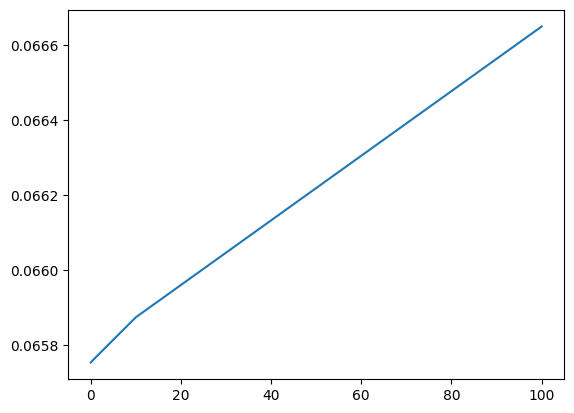

Best lambda value: 100
Test MSE for best Lasso model: 208391964692343.38
RMSE for best Lasso model: 14435787.636715338


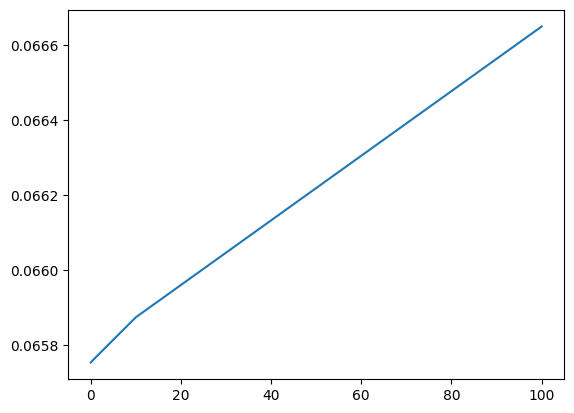

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
full_df_simplified = full_df_simplified[full_df_simplified['current_number_of_funding_rounds'] < 4]

full_df_simplified_less = full_df_simplified[full_df_simplified['next_round_raised_amount_usd'] < 20000000]
full_df_simplified_more = full_df_simplified[full_df_simplified['next_round_raised_amount_usd'] >= 20000000]

test_set, discard_set = train_test_split(full_df_simplified_more, test_size=0.2, random_state=42)

# Combine the training set with the discard set
final_train_set = pd.concat([full_df_simplified_more, discard_set])

X_train = final_train_set.drop('next_round_raised_amount_usd', axis=1)
Y_train = final_train_set['next_round_raised_amount_usd']

# And for the test_set
X_test = test_set.drop('next_round_raised_amount_usd', axis=1)
Y_test = test_set['next_round_raised_amount_usd']
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=2/9, random_state=42)

# Train the model on the new training set
model = LinearRegression()
model.fit(X_train, y_train)


# # Predicting on test data
y_pred = model.predict(X_test)

from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_validate

lambdas = [0.01, 0.1, 1, 10, 100]
best_score = float("-inf")
best_lambda = 0
scores = []

for l in lambdas:
    ridge_reg = Ridge(alpha=l)
    ridge_reg.fit(X_train, y_train)
    score = ridge_reg.score(X_val, y_val)

    #res = cross_validate(ridge_reg, X_train, y_train, cv=5, return_train_score=True)
    #score = res['test_score'].mean()
    #scores.append(score)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_lambda = l



best_ridge = Ridge(alpha=best_lambda)
best_ridge.fit(X_train, y_train)
y_test_pred_ridge = best_ridge.predict(X_test)


test_mse_ridge = mean_squared_error(Y_test, y_test_pred_ridge)
print(f"Best lambda value: {best_lambda}")
print(f"Test MSE for best Ridge model: {test_mse_ridge}")
print(f"RMSE for best Ridge model: {np.sqrt(test_mse_ridge)}")
plt.plot(lambdas, scores)
plt.show()

lambdas_lasso = [0.01, 0.1, 1, 10, 100]
best_score_lasso = float("-inf")
best_lambda_lasso = 0
scores_lasso = []

for l in lambdas_lasso:
    ridge_reg = Ridge(alpha=l)
    ridge_reg.fit(X_train, y_train)
    score = ridge_reg.score(X_val, y_val)
    scores_lasso.append(score)
    if score > best_score_lasso:
        best_score_lasso = score
        best_lambda = l



best_lasso = Lasso(alpha=best_lambda)
best_lasso.fit(X_train, y_train)
y_test_pred_lasso = best_lasso.predict(X_test)

print(f"Best lambda value: {best_lambda}")
test_mse_lasso = mean_squared_error(Y_test, y_test_pred_lasso)
print(f"Test MSE for best Lasso model: {test_mse_lasso}")
print(f"RMSE for best Lasso model: {np.sqrt(test_mse_lasso)}")
plt.plot(lambdas_lasso, scores_lasso)
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred_ridge))
print(f"RIDGE RMSE: {rmse}")

# Calculating RMSE
rmse = np.sqrt(mean_squared_error(Y_test, y_test_pred_lasso))

print(f"LASSO RMSE: {rmse}")

# Viewing coefficients to understand feature importance
feature_importance = pd.DataFrame(model.coef_, index=X_test.columns, columns=['Coefficient'])
print(feature_importance)


RIDGE RMSE: 14436402.254523499
LASSO RMSE: 14435787.636715338
                                   Coefficient
funding_rounds                    2.510382e+05
raised_amount_usd                 1.834969e+06
total_funding_until_this_point    1.939743e+06
current_number_of_funding_rounds -9.022968e+05
company_age_at_funding            2.468820e+05
time_since_last_round             2.939310e+05


In [ ]:
residuals = abs(Y_test - y_test_pred_ridge)
residuals.describe()
#residuals.hist(bins=15)
#plt.show()


#residuals = abs(Y_test - y_test_pred_lasso)
#residuals.describe()
#residuals.hist(bins=15)
#plt.show()


count    1.529000e+03
mean     1.072565e+07
std      9.665981e+06
min      2.236434e+04
25%      4.710737e+06
50%      8.675260e+06
75%      1.295997e+07
max      6.570177e+07
Name: next_round_raised_amount_usd, dtype: float64

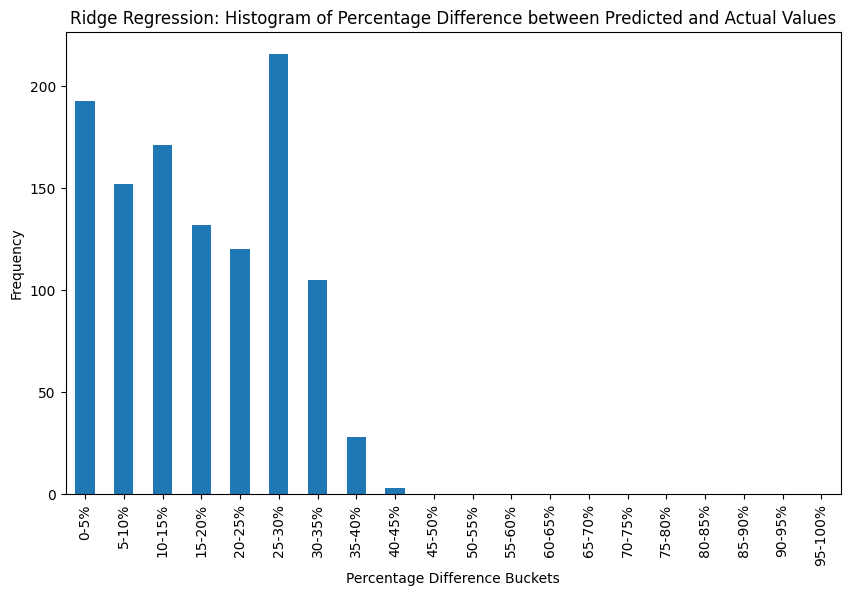

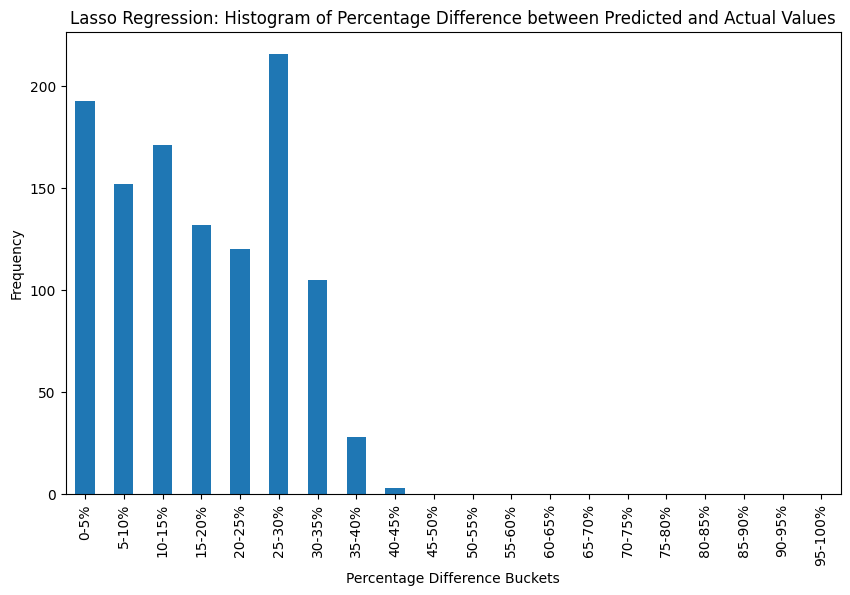

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the percentage difference
percentage_diff = abs((Y_test - y_test_pred_ridge) / Y_test) * 100

# Categorize into buckets
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%', '65-70%', '70-75%', '75-80%', '80-85%', '85-90%', '90-95%', '95-100%']
percentage_diff_binned = pd.cut(percentage_diff, bins=bins, labels=labels, include_lowest=True)

# Plot histogram
plt.figure(figsize=(10,6))
percentage_diff_binned.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Percentage Difference Buckets')
plt.ylabel('Frequency')
plt.title('Ridge Regression: Histogram of Percentage Difference between Predicted and Actual Values')
plt.show()

# Calculate the percentage difference
percentage_diff = abs((Y_test - y_test_pred_lasso) / Y_test) * 100

# Categorize into buckets
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['0-5%', '5-10%', '10-15%', '15-20%', '20-25%', '25-30%', '30-35%', '35-40%', '40-45%', '45-50%', '50-55%', '55-60%', '60-65%', '65-70%', '70-75%', '75-80%', '80-85%', '85-90%', '90-95%', '95-100%']
percentage_diff_binned = pd.cut(percentage_diff, bins=bins, labels=labels, include_lowest=True)

# Plot histogram
plt.figure(figsize=(10,6))
percentage_diff_binned.value_counts(sort=False).plot(kind='bar')
plt.xlabel('Percentage Difference Buckets')
plt.ylabel('Frequency')
plt.title('Lasso Regression: Histogram of Percentage Difference between Predicted and Actual Values')
plt.show()

<Axes: >

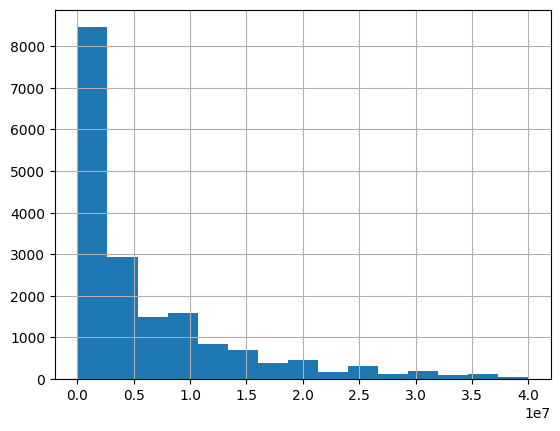

In [ ]:
full_df_simplified.describe()
full_df_simplified['next_round_raised_amount_usd'].hist(bins=15)